In [62]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [63]:
import pathlib
data_dir = pathlib.Path('C:/Users/Rodrigo/AlgoTrading/output/fromMatt2')

In [64]:
data_dir

WindowsPath('C:/Users/Rodrigo/AlgoTrading/output/fromMatt2')

In [65]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

186


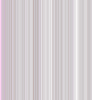

In [66]:
buyModel = list(data_dir.glob('buyModel/*'))
PIL.Image.open(str(buyModel[0]))

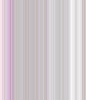

In [67]:
PIL.Image.open(str(buyModel[1]))

In [168]:
batch_size = 32
img_height = 100
img_width = 180

### What will happen if batch_size is changed???
https://stats.stackexchange.com/a/153535
The batch size defines the number of samples that will be propagated through the network.

For instance, let's say you have 1050 training samples and you want to set up a batch_size equal to 100. The algorithm takes the first 100 samples (from 1st to 100th) from the training dataset and trains the network. Next, it takes the second 100 samples (from 101st to 200th) and trains the network again. We can keep doing this procedure until we have propagated all samples through of the network. Problem might happen with the last set of samples. In our example, we've used 1050 which is not divisible by 100 without remainder. The simplest solution is just to get the final 50 samples and train the network.

Advantages of using a batch size < number of all samples:

It requires less memory. Since you train the network using fewer samples, the overall training procedure requires less memory. That's especially important if you are not able to fit the whole dataset in your machine's memory.

Typically networks train faster with mini-batches. That's because we update the weights after each propagation. In our example we've propagated 11 batches (10 of them had 100 samples and 1 had 50 samples) and after each of them we've updated our network's parameters. If we used all samples during propagation we would make only 1 update for the network's parameter.

Disadvantages of using a batch size < number of all samples:

The smaller the batch the less accurate the estimate of the gradient will be. In the figure below, you can see that the direction of the mini-batch gradient (green color) fluctuates much more in comparison to the direction of the full batch gradient (blue color).

In [69]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
 color_mode='rgba')

Found 186 files belonging to 2 classes.
Using 149 files for training.


In [70]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode='rgba')

Found 186 files belonging to 2 classes.
Using 37 files for validation.


In [71]:
class_names = train_ds.class_names
print(class_names)

['buyModel', 'other']


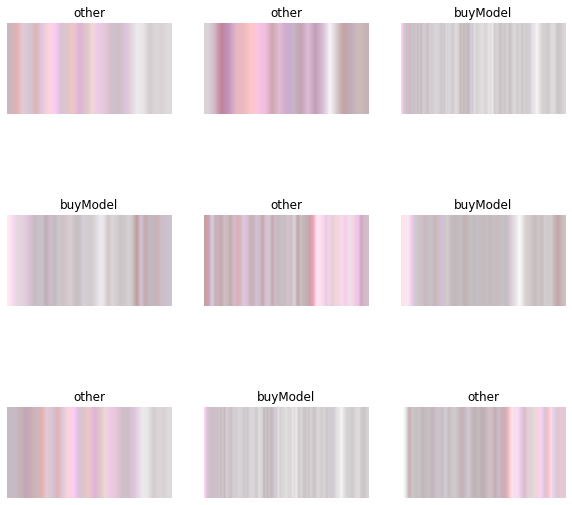

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [73]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [74]:
normalization_layer = layers.Rescaling(1./255)

In [75]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [179]:
# train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 180, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [76]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 4)),
#   layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

In [133]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 4)),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(512, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(1024, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dense(num_classes)
])

In [77]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [79]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [78]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 100, 180, 4)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 100, 180, 64)      2368      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 50, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 50, 90, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 25, 45, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 25, 45, 256)      

In [163]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
5/5 [==============================] - 7s 2s/step - loss: 0.4355 - accuracy: 0.8255 - val_loss: 0.4242 - val_accuracy: 0.7838
Epoch 2/10
5/5 [==============================] - 7s 1s/step - loss: 0.2491 - accuracy: 0.9060 - val_loss: 0.4410 - val_accuracy: 0.8649
Epoch 3/10
5/5 [==============================] - 7s 1s/step - loss: 0.1991 - accuracy: 0.9396 - val_loss: 0.5001 - val_accuracy: 0.8649
Epoch 4/10
5/5 [==============================] - 7s 2s/step - loss: 0.1781 - accuracy: 0.9597 - val_loss: 0.4515 - val_accuracy: 0.8649
Epoch 5/10
5/5 [==============================] - 7s 1s/step - loss: 0.1665 - accuracy: 0.9664 - val_loss: 0.3766 - val_accuracy: 0.8919
Epoch 6/10
5/5 [==============================] - 7s 2s/step - loss: 0.1312 - accuracy: 0.9732 - val_loss: 0.3443 - val_accuracy: 0.8919
Epoch 7/10
5/5 [==============================] - 7s 1s/step - loss: 0.1179 - accuracy: 0.9597 - val_loss: 0.2737 - val_accuracy: 0.8919
Epoch 8/10
5/5 [=========================

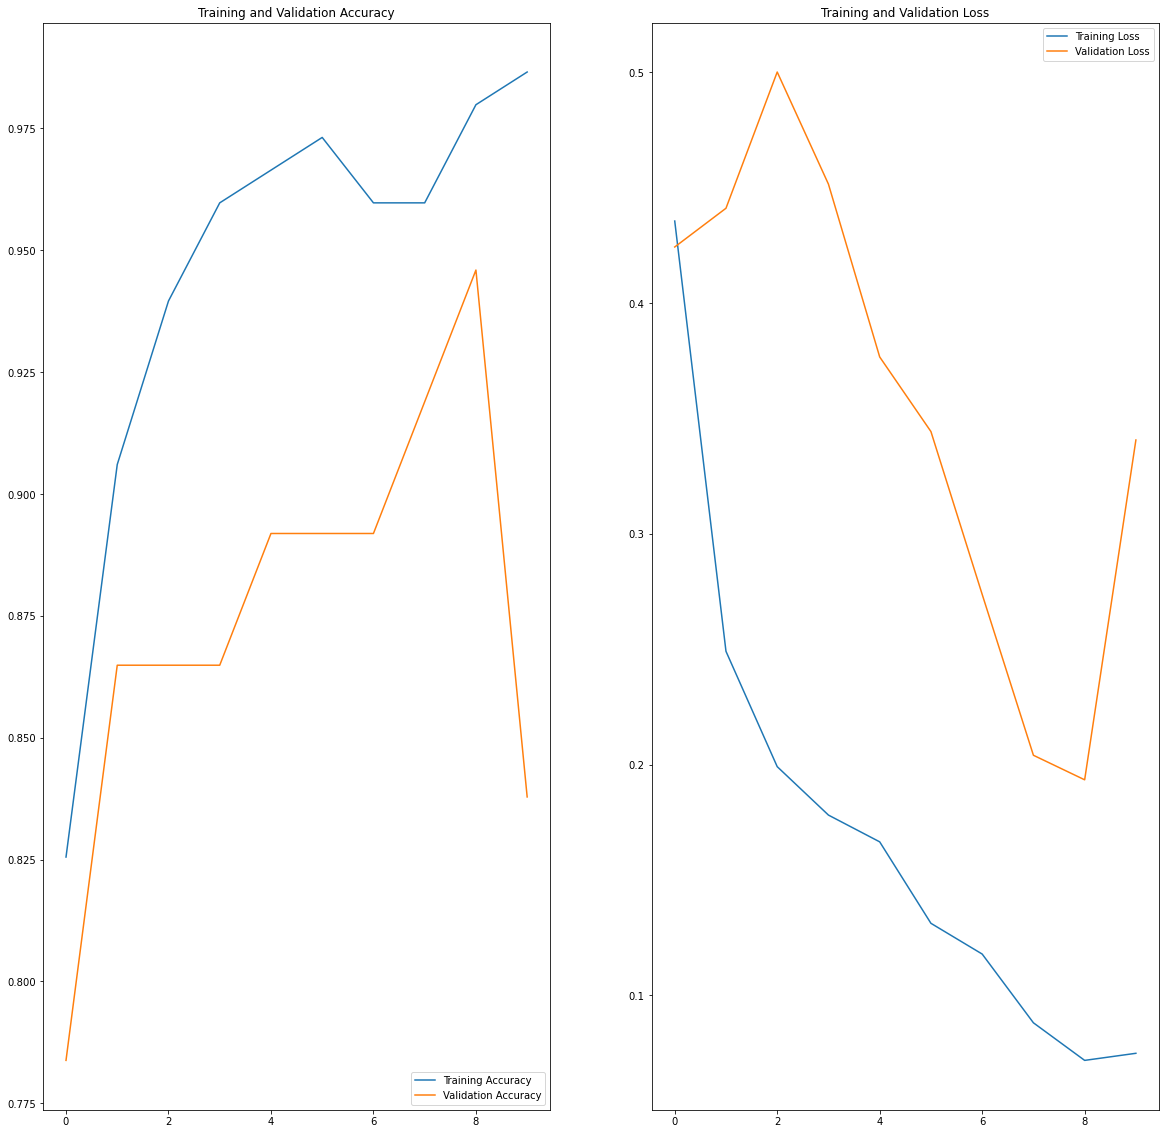

In [164]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [167]:
# model.save('./a-buy-model-7')
#model-6 is the latest and best model so far

INFO:tensorflow:Assets written to: ./a-buy-model-6\assets


In [176]:
# serialize model to JSON
# model_json = model.to_json()
# with open("./model6-json/model.json", "w") as json_file:
#     json_file.write(model_json)
# # # serialize weights to HDF5
# model.save_weights("./model6-json/model.h5")
# print("Saved model to disk")

### THIS DIDNT WORK EITHER
# import tensorflowjs as tfjs
# tfjs.converters.save_keras_model(model, './model6-json/')
# Best way to save the model for JS is to use this
# tensorflowjs_converter --input_format=tf_saved_model --output_node_names='MobilenetV1/Predictions/Reshape_1' 
# --saved_model_tags=serve ./a-buy-model-6/ ./model6-json


In [187]:
# import tensorflowjs as tfjs
# tfjs.converters.save_keras_model(model, './a-buy-model-6-keras/')

# model_json = model.to_json()
# with open("./a-buy-model-6-keras/model.json", "w") as json_file:
#     json_file.write(model_json)
# # # serialize weights to HDF5
# model.save_weights("./a-buy-model-6-keras/model.h5")
# print("Saved model to disk")

model.save('./a-buy-model-6-keras/model.h5', save_format='h5')

# Then run this in the terminal:
# tensorflowjs_converter --input_format=keras .\model.h5 .\test\

In [188]:
model.save('./path-to-save/model.h5', save_format='h5')
    # Then run this in the terminal to convert the keras h5 model to a layer model for tfjs
! tensorflowjs_converter --input_format=keras ./path-to-save/model.h5 ./path-to-save/output/

2022-03-20 00:54:48.343804: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-03-20 00:54:48.343834: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Best way to save the model for JS is to use this
    tensorflowjs_converter --input_format=tf_saved_model --output_node_names='MobilenetV1/Predictions/Reshape_1' 
    --saved_model_tags=serve ./a-buy-model-6/ ./model6-json

In [158]:
# ONLINE TRAINING!!!!
continous_dir = pathlib.Path("C:/Users/Rodrigo/AlgoTrading/morefail/")


# # image_count = len(list(continous_dir.glob('*/*.png')))
# # print(image_count)
# # moreTrain_ds

moreTrain_ds = tf.keras.utils.image_dataset_from_directory(
  continous_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
 color_mode='rgba')

# val_ds
myHistory = model.fit(
  moreTrain_ds,
#   validation_data=val_ds,
  epochs=2
)

Found 4 files belonging to 1 classes.
Epoch 1/2
1/1 [==============================] - 0s 214ms/step - loss: 18.5513 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 222ms/step - loss: 8.1109 - accuracy: 0.0000e+00


In [165]:
# Training in the entire dataset
data_dir = pathlib.Path('C:/Users/Rodrigo/AlgoTrading/output/fromMatt2')
totaltrain_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
 color_mode='rgba')

Found 186 files belonging to 2 classes.


In [166]:
epochs=10
history = model.fit(
  totaltrain_ds,
  epochs=epochs
)

Epoch 1/10
6/6 [==============================] - 8s 1s/step - loss: 0.0956 - accuracy: 0.9462
Epoch 2/10
6/6 [==============================] - 8s 1s/step - loss: 0.0893 - accuracy: 0.9839
Epoch 3/10
6/6 [==============================] - 8s 1s/step - loss: 0.0742 - accuracy: 0.9839
Epoch 4/10
6/6 [==============================] - 8s 1s/step - loss: 0.0397 - accuracy: 0.9946
Epoch 5/10
6/6 [==============================] - 9s 1s/step - loss: 0.0360 - accuracy: 0.9892
Epoch 6/10
6/6 [==============================] - 8s 1s/step - loss: 0.0695 - accuracy: 0.9677
Epoch 7/10
6/6 [==============================] - 8s 1s/step - loss: 0.0362 - accuracy: 0.9892
Epoch 8/10
6/6 [==============================] - 8s 1s/step - loss: 0.0456 - accuracy: 0.9731
Epoch 9/10
6/6 [==============================] - 8s 1s/step - loss: 0.0175 - accuracy: 0.9946
Epoch 10/10
6/6 [==============================] - 8s 1s/step - loss: 0.0141 - accuracy: 1.0000


In [149]:
img = tf.keras.utils.load_img(
    'C:/Users/Rodrigo/AlgoTrading/testing3.png', target_size=(img_height, img_width), color_mode='rgba'
)
# img = tf.keras.utils.load_img(
#     'C:/Users/Rodrigo/AlgoTrading/output/fromMatt2/other/27.png', target_size=(img_height, img_width), color_mode='rgba'
# )
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)

score = tf.nn.softmax(predictions[0])
print(score)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

tf.Tensor([0.07499742 0.9250026 ], shape=(2,), dtype=float32)
This image most likely belongs to other with a 92.50 percent confidence.
